In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import random
import numpy as np
import cv2
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import copy
import sys
sys.path.append('../')

from src import(
    KeypointDataset,
    seed_everything,
    get_test_transforms,
    get_valid_transforms,
    draw_keypoint,
    softargmax2d,
)

In [72]:
seed_everything(42)
class Config():
    # device = "cuda:0" if torch.cuda.is_available() else "cpu"
    device = "cpu"
    base_path = '../data/resized_scale5/'
    checkpoint = '../checkpoint/scale5_w_mre'
    weight_fn = os.path.join(checkpoint, 'model_loss_best.pth')
    assert os.path.isdir(base_path)
    assert os.path.isdir(checkpoint)
    assert os.path.isfile(weight_fn)

In [73]:
import segmentation_models_pytorch as smp
model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    encoder_depth=5,
    decoder_attention_type='scse',
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=30,                      # model output channels (number of classes in your dataset)
    activation='softmax',
)
model.load_state_dict(torch.load(Config.weight_fn))
model.to(Config.device)
model.eval();

In [74]:
label_df = pd.read_csv(os.path.join('../data/', 'data_split.csv'))
test_df = label_df[label_df['phase']=='valid']

test_dataset = KeypointDataset(
    base_path=Config.base_path,
    label_df=test_df,
    transforms=get_valid_transforms(),
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


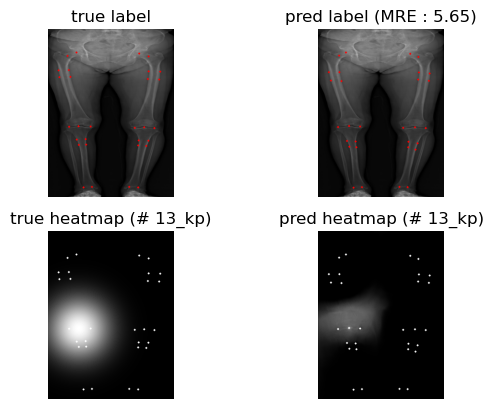

In [81]:
target = random.choice(test_dataset)
image = target['input'].to(Config.device).unsqueeze(dim=0)
mask = target['target'].squeeze()

true_keypoints = softargmax2d(mask).detach().numpy()
true_keypoints = [true_keypoint for true_keypoint in true_keypoints]

pred = model(image).squeeze()
pred_keypoints = softargmax2d(pred).detach().numpy()
pred_keypoints = [pred_keypoint for pred_keypoint in pred_keypoints]

true_kp_np = np.array(true_keypoints)
pred_kp_np = np.array(pred_keypoints)
mre = round(np.mean(np.sqrt(np.sum(np.power((true_kp_np - pred_kp_np), 2), axis=-1))), 2)

mask = mask.detach().numpy()
pred = pred.detach().numpy()

image_raw = copy.copy(image[0].detach().cpu().numpy().transpose(1, 2, 0))
image_raw = cv2.cvtColor(image_raw,cv2.COLOR_GRAY2RGB)

# pred = [cv2.cvtColor((p * 255.0).astype('int'), cv2.COLOR_GRAY2RGB)for p in pred]
# mask = [cv2.cvtColor((m * 255.0).astype('int'), cv2.COLOR_GRAY2RGB)for m in mask]
# pred = [cv2.cvtColor(cv2.applyColorMap((p * 255).astype(np.uint8), cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)for p in pred]
# mask = [cv2.cvtColor(cv2.applyColorMap((m * 255).astype(np.uint8), cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)for m in mask]

image_p = copy.copy(pred)
image_t = copy.copy(mask)

key_pt_idx =random.randint(0, 29)
true_gray = draw_keypoint(img=image_raw, keypoints=true_keypoints, scale=0.1, text=False)
pred_gray = draw_keypoint(img=image_raw, keypoints=pred_keypoints, scale=0.1, text=False)
true_map = draw_keypoint(img=image_t[key_pt_idx] * 255, keypoints=true_keypoints, scale=0.1, text=False)
pred_map = draw_keypoint(img=pred[key_pt_idx] * 255, keypoints=pred_keypoints, scale=0.1, text=False)

plt.subplot(2,2,1)
plt.axis('off')
plt.title('true label')
plt.imshow(true_gray)

plt.subplot(2,2,2)
plt.axis('off')
plt.title(f'pred label (MRE : {mre})')
plt.imshow(pred_gray)

plt.subplot(2,2,3)
plt.axis('off')
plt.title(f'true heatmap (# {key_pt_idx}_kp)')
plt.imshow(true_map, 'gray')

plt.subplot(2,2,4)
plt.axis('off')
plt.title(f'pred heatmap (# {key_pt_idx}_kp)')
plt.imshow(pred_map, 'gray')
plt.show()